<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#0-Preliminaries" data-toc-modified-id="0-Preliminaries-1">0 Preliminaries</a></span><ul class="toc-item"><li><span><a href="#0.0-Importing-Packages-and-Modules" data-toc-modified-id="0.0-Importing-Packages-and-Modules-1.1">0.0 Importing Packages and Modules</a></span></li></ul></li><li><span><a href="#1-Importation" data-toc-modified-id="1-Importation-2">1 Importation</a></span></li><li><span><a href="#2-Missing-data" data-toc-modified-id="2-Missing-data-3">2 Missing data</a></span><ul class="toc-item"><li><span><a href="#2.0-Global-view" data-toc-modified-id="2.0-Global-view-3.1">2.0 Global view</a></span></li><li><span><a href="#2.1-Drop-features-with-too-much-missing-data" data-toc-modified-id="2.1-Drop-features-with-too-much-missing-data-3.2">2.1 Drop features with too much missing data</a></span></li><li><span><a href="#2.1-Filling-missing-values" data-toc-modified-id="2.1-Filling-missing-values-3.3">2.1 Filling missing values</a></span><ul class="toc-item"><li><span><a href="#Quantitative" data-toc-modified-id="Quantitative-3.3.1">Quantitative</a></span></li><li><span><a href="#Categorical" data-toc-modified-id="Categorical-3.3.2">Categorical</a></span></li></ul></li></ul></li><li><span><a href="#3-Exportation" data-toc-modified-id="3-Exportation-4">3 Exportation</a></span></li></ul></div>

# "Implémentez un modèle de scoring"
_Cleaning the data_


References used for this notebook:

- "https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda"

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Mounting my Drive if on Colab

In [367]:
# from google.colab import files, output, drive
# drive.mount('/gdrive')
# %cd /gdrive

In [368]:
%pwd

'C:\\Users\\Maryse\\Google Drive\\--DATA SCIENCE\\PROJET7\\NOTEBOOKS'

Installations and importations required in the virtual environment.

In [369]:
# import os
# os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET7/NOTEBOOKS')
# # !pip install -r requirements.txt

In [370]:
from P7_functions import *

Installations (creating the requirements file)

In [371]:
# !pip freeze > requirements_merging.txt

Importation of modules and packages. 

In [372]:
import io
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Setting pandas display options.

In [373]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

Additional functions

In [374]:
# To play audio text-to-speech during execution

from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

## 1 Importation

In [375]:
# ### Pickling the aggregated dataset

# import dill as pickle

# with open('dict_df_agg.pkl', 'wb') as file:
#     pickle.dump(dict_df, file)

In [376]:
### Importation

import dill as pickle

with open('dict_df_agg.pkl', 'rb') as file:
    dict_df = pickle.load(file)

In [377]:
# set SK_ID_CURR as the index (and thus exclude of the analysis)

dict_df['app_train'] = dict_df['app_train'].set_index('SK_ID_CURR')

In [378]:
X_train = dict_df['app_train'].drop(columns=['TARGET']).copy('deep')
y_train = dict_df['app_train']['TARGET'].copy('deep')

In [379]:
#### Exploring values of the remaining columns

# get categorical and quantitative columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns
quant_cols = X_train.select_dtypes(include=[np.number]).columns

# get binary columns
bin_cols = X_train.columns[X_train.nunique()==2]

# get integer columns
int_cols = \
    [c for c in X_train.select_dtypes(include=['int']).columns \
                                                if c not in bin_cols]
# get float columns
f64_cols = \
    [c for c in X_train.select_dtypes(include=['float64']).columns \
                                                if c not in bin_cols]
f64_low_nunique = \
    X_train[f64_cols].columns\
            [X_train[f64_cols].nunique()<100]
f64_high_nunique = \
    X_train[f64_cols].columns\
            [X_train[f64_cols].nunique()>=100]

low_nunique = list(f64_low_nunique) + int_cols + list(cat_cols) + list(bin_cols)

## 2 Missing data

### 2.0 Global view

<AxesSubplot:ylabel='SK_ID_CURR'>

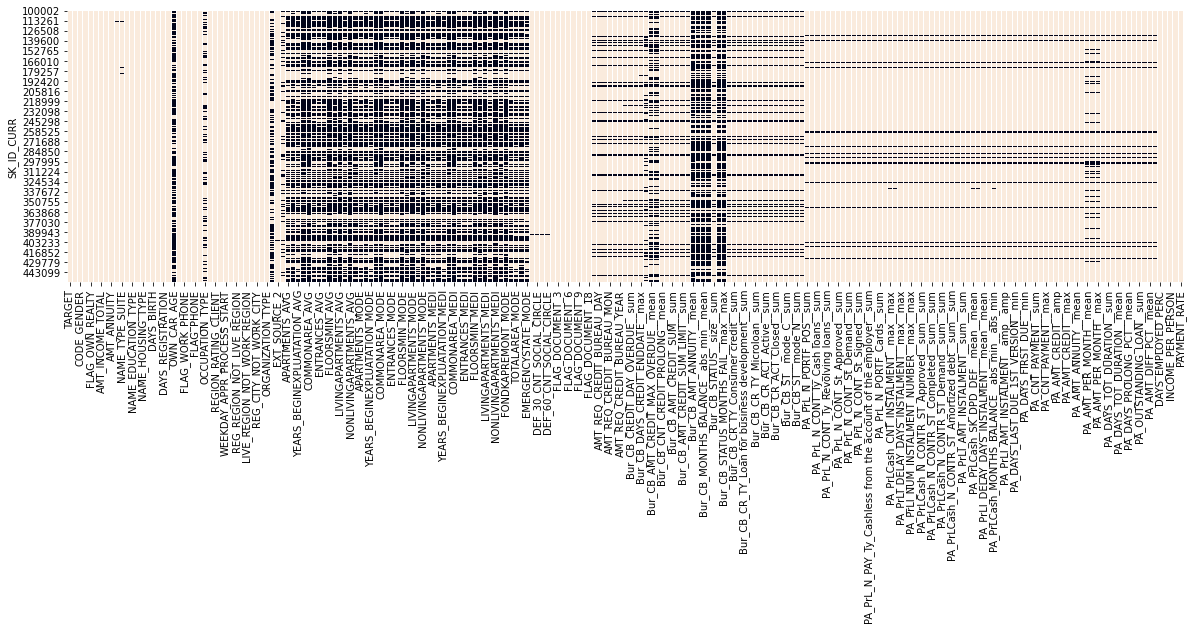

In [380]:
# global view of the missing values (black)

plt.figure(figsize=(20,5))
sns.heatmap(dict_df['app_train'].notna(), cbar=False)

In [381]:
# Have a overview of the missing values

df_miss = missing_data(dict_df['app_train'])

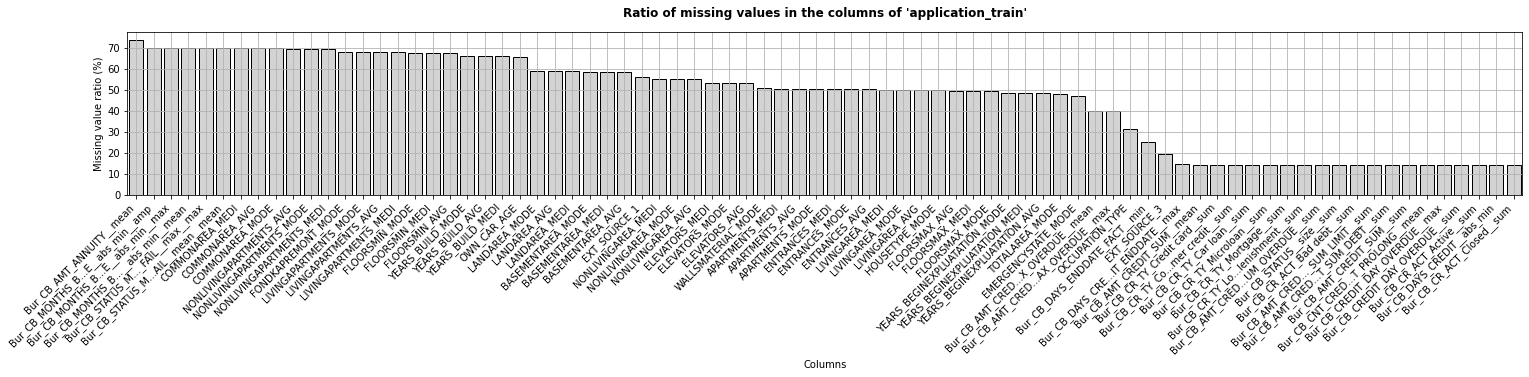

In [382]:
plot_simple_barplot(x = df_miss.index[:80],
                    y = df_miss['Percent'].iloc[:80],
                    x_lab='Columns', y_lab='Missing value ratio (%)',
                    title="Ratio of missing values in the columns of 'application_train'",
                    shorten_label=15, figsize=(25,3), color='lightgrey')

In [383]:
# display the number and the name of the columns to delete because exceeding 50% missing values

miss_more_45_cols = X_train[df_miss[df_miss['Percent']>45].index].columns
print(len(miss_more_45_cols), list(miss_more_45_cols))

55 ['Bur_CB_AMT_ANNUITY__mean', 'Bur_CB_MONTHS_BALANCE__abs_min__amp', 'Bur_CB_MONTHS_BALANCE__abs_min__max', 'Bur_CB_MONTHS_BALANCE__abs_min__mean', 'Bur_CB_STATUS_MONTHS_FAIL__max__max', 'Bur_CB_STATUS_MONTHS_FAIL__mean__mean', 'COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI', 'FLOORSMIN_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI', 'OWN_CAR_AGE', 'LANDAREA_MODE', 'LANDAREA_AVG', 'LANDAREA_MEDI', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'EXT_SOURCE_1', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'ELEVATORS_AVG', 'WALLSMATERIAL_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'ENTRANCES_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_

### 2.1 Drop features with too much missing data

In [384]:
# see nb of columns before dropping

ser_miss = missing_data(X_train)['Percent']
no_miss_cols = ser_miss.loc[ser_miss==0].index
miss_cols = [col for col in X_train.columns if col not in no_miss_cols]
len(miss_cols), len(no_miss_cols)

(176, 38)

In [385]:
# keep only features with more than 55% notna values

X_train = X_train.drop(columns=miss_more_45_cols)

### 2.1 Filling missing values

In [386]:
# see nb of columns after dropping features with less than 55% notna

ser_miss = missing_data(X_train)['Percent']
no_miss_cols = ser_miss.loc[ser_miss==0].index
miss_cols = [col for col in X_train.columns if col not in no_miss_cols]
len(miss_cols), len(no_miss_cols)

(121, 38)

#### Quantitative

In [387]:
# case 0 : columns coming from aggregation (__sum, __mean, __max, __min, __size, __sum, _amp, __abs_min )

cols_agg = X_train.columns[X_train.columns.str.contains(
    '__sum|__max|__min|__mean|__size|__sum|__amp|__abs_min')]
X_train[cols_sum] = X_train[cols_sum].fillna(0)

miss_cols = [col for col in miss_cols if col not in cols_agg]

In [388]:
# case 1 continuous numerical values
miss_numb_cols = X_train[miss_cols].select_dtypes(include=[np.number]).columns

# case 1.1: almost totally filled (>99%), can be easily infered (median)
miss_few_numb_cols = ser_miss.loc[miss_numb_cols][ser_miss.loc[miss_numb_cols]<1].index

for c in miss_few_numb_cols:
    X_train[c] = X_train[c].fillna(X_train[c].median())

In [389]:
# case 1.2: between 1% and 32%
miss_much_numb_cols = ser_miss.loc[miss_numb_cols][ser_miss.loc[miss_numb_cols]>=1].index
# some of these quantitative columns have in fact few unique values -> to categories
miss_numb_to_cat = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR']
miss_much_numb_cols = [col for col in miss_much_numb_cols if col not in miss_numb_to_cat]

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, f_classif

for col in miss_much_numb_cols:
    
    print(f'-----{col}')
    
    ind_no_miss = list(X_train[X_train[col].notna()].index)
    ind_miss = list(X_train[X_train[col].isna()].index)
    
    # select features for knn inference unsing SelectKBest
    sel_k = SelectKBest(k=8, score_func=f_regression)

    num_filled_col = X_train[no_miss_cols].select_dtypes(include=[np.number]).columns
    sel_k.fit(X_train.loc[ind_no_miss, num_filled_col], X_train.loc[ind_no_miss, col])
    best_cols = list(num_filled_col[sel_k.get_support(indices=True)])
    print("features used for the model", best_cols)

    # machine learning model imputer
    var_model = best_cols
    var_target = col
    ind_sample = random.sample(ind_no_miss, 5000) + ind_miss
    ind_to_impute, y_pr_ = model_impute(X_train.loc[ind_sample],
                                        var_model = var_model,
                                        var_target=var_target,
                                        enc_strat_cat='label',
                                        n_model='rf', plot=False)
    print('-> Number of values to impute:', len(ind_to_impute))

    #replace nan values
    X_train.loc[ind_to_impute, col] = y_pr_

-----EXT_SOURCE_3
features used for the model ['DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_EMPLOYED_PERC', 'FLAG_EMP_PHONE', 'REG_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY']
--- model: -0.0282
--- normal random distribution: -33.2
--- dummy regressor (mean) : r2_score=-0.000217
--- dummy regressor (median) : r2_score=-0.0115
-> Number of values to impute: 60965


The models (either knn or random forest) to impute 'EXT_SOURCE_3' are very inaccurate...

In [390]:
# see missing rate after filling quantitative missing values

ser_miss = missing_data(X_train)['Percent']
no_miss_cols = ser_miss.loc[ser_miss==0].index
miss_cols = [col for col in X_train.columns if col not in no_miss_cols]
len(miss_cols), len(no_miss_cols)

(11, 148)

#### Categorical

In [391]:
X_train[miss_cols].select_dtypes(exclude=[np.number]).columns

Index(['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
       'OCCUPATION_TYPE'],
      dtype='object')

In [392]:
# case 2 categories
miss_cat_cols = X_train[miss_cols].select_dtypes(exclude=[np.number]).columns

# case 2.1: almost totally filled (>99%), can be easily infered (more frequent)
miss_few_cat_cols = ser_miss.loc[miss_cat_cols][ser_miss.loc[miss_cat_cols]<1].index

for c in miss_few_cat_cols:
    X_train[c] = X_train[c].fillna(X_train[c].mode()[0])
    
# case 2.2: missing more than 1%, infered using KNN classifier
miss_much_cat_cols = list(ser_miss.loc[miss_cat_cols][ser_miss.loc[miss_cat_cols]>1].index)
miss_much_cat_cols = miss_much_cat_cols + miss_numb_to_cat

for c in miss_much_cat_cols:
    X_train[c] = X_train[c].fillna(X_train[c].mode()[0])

We tried KNN imputation on the categorical column 'OCCUPATION_TYPE' with 32% missing value (see code below) but the score is worse (f1=0.23) than with imputation by most frequent value (f1=0.25).

We thus imputed (see above) using most frequent value.

In [393]:
# # Data preprocessing, Knn training, then predicting (all-in-one function)
# # infer 'OCCUPATION_TYPE' from 25 TARGET most representative columns (SelectKBest)

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_regression, f_classif

# # X_train[miss_much_cat_cols] = X_train[miss_much_cat_cols].astype('object')

# for col in miss_much_cat_cols:
    
#     print(f'-----{col}')
#     ind_no_miss = list(X_train[X_train[col].notna()].index)
#     ind_miss = list(X_train[X_train[col].isna()].index)
#     # select features for knn inference unsing SelectKBest
#     sel_k = SelectKBest(k=8, score_func=f_classif)
#     num_filled_col = X_train[no_miss_cols].select_dtypes(include=[np.number]).columns
#     sel_k.fit(X_train.loc[ind_no_miss, num_filled_col],
#               X_train.loc[ind_no_miss, col])
#     best_cols = list(num_filled_col[sel_k.get_support(indices=True)])
#     print("features used for the model", best_cols)

#     # machine learning model imputer
#     var_model = best_cols
#     var_target = col
#     ind_sample = random.sample(ind_no_miss, 5000) + ind_miss
#     ind_to_impute, y_pr_ = model_impute(X_train.loc[ind_sample],
#                                         var_model = var_model,
#                                         var_target=var_target,
#                                         enc_strat_cat='label',
#                                         n_model='knn', plot=False)
#     print('-> Number of values to impute:', len(ind_to_impute))

# #     #replace nan values
# #     X_train.loc[ind_to_impute, col] = y_pr_


In [394]:
# recompute missing columns
ser_miss = missing_data(X_train)['Percent']
no_miss_cols = ser_miss.loc[ser_miss==0].index
miss_cols = [col for col in X_train.columns if col not in no_miss_cols]
len(miss_cols), len(no_miss_cols)

(0, 159)

## 3 Exportation

In [ ]:
### Pickling the aggregated dataset

import dill as pickle

with open('dict_df_cleaned.pkl', 'wb') as file:
    pickle.dump(dict_df, file)

In [ ]:
# ### Importation
# import dill as pickle
# with open('dict_df_cleaned.pkl', 'rb') as file:
#     dict_df = pickle.load(file)